In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

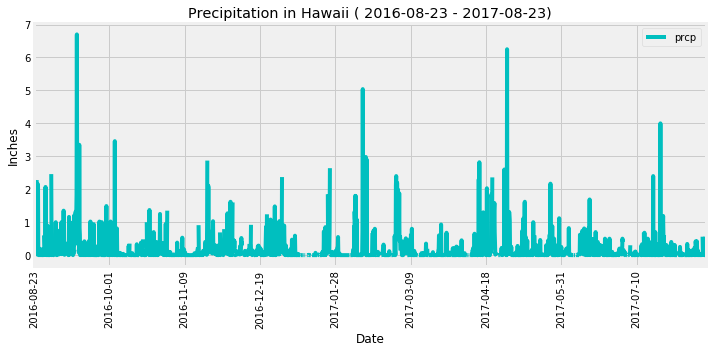

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# get latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#using ravel to extract string from the above query object
latest_date = list(np.ravel(latest_date))[0]

#converting the string returned above to datetime format
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

#calculating the date 1 years ago using timedelta
date_year_ago = (latest_date - dt.timedelta(days=365)).date()

# Perform a query to retrieve the data and precipitation scores
prcp_result = session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date >= date_year_ago ).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_result)
prcp_df.set_index("date",inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(ascending = True,inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize = (10,5),rot = 90,color = 'c')
plt.title(f"Precipitation in Hawaii ( {date_year_ago} - {latest_date.date()})")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/Precipitation_Plot.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"Number of stations available in the dataset: {station_count}")

Number of stations available in the dataset: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_id = active_stations[0][0]

results = session.query(Measurement.station,Station.name,func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.station == Station.station ).filter(Measurement.station == most_active_station_id).all()


print(f"Most active station is {results[0][0]} - {results[0][1]}")
print(f"The lowest temperature recorded is {results[0][2]} F")
print(f"The average temperature recorded is {round(results[0][3],2)} F")
print(f"The highest temperature recorded is {results[0][4]} F")

Most active station is USC00519281 - WAIHEE 837.5, HI US
The lowest temperature recorded is 54.0 F
The average temperature recorded is 71.66 F
The highest temperature recorded is 85.0 F


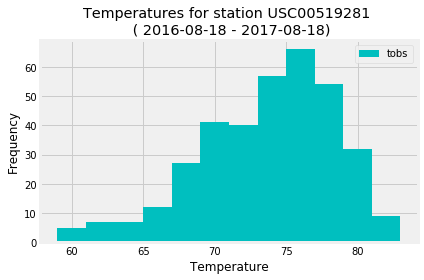

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


#get station with most temperature observations
st_with_most_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.tobs).desc())\
                        .first()

station_id = st_with_most_temp_obs[0]


# get latest date
latest_date_for_station = session.query(Measurement.date).filter(Measurement.station == station_id)\
                          .order_by(Measurement.date.desc()).first()

#using ravel to extract string from the above query object
latest_date_for_station = list(np.ravel(latest_date_for_station))[0]

#converting the string returned above to datetime format
latest_date_for_station = dt.datetime.strptime(latest_date_for_station, '%Y-%m-%d')

#calculating the date 1 years ago using timedelta
date_year_ago_for_station = (latest_date_for_station - dt.timedelta(days=365)).date()

# Temperature Observations for the station for last 12 months
Temp_result = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= date_year_ago_for_station ).\
                    filter(Measurement.station == station_id).all()


# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(Temp_result)

#plot histogram with bins =12
temp_df.plot(kind='hist', bins=12,color = 'c')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperatures for station {station_id} \n ( {date_year_ago_for_station} - {latest_date_for_station.date() })')
plt.tight_layout()
plt.savefig('Images\Temp_Histogram.png')
plt.show()


## Bonus Challenge Assignment

### Temperature Analysis I

In [16]:
# Create a function that will calculate the average temperature for a given month across all years in the data set

def Avg_temp(date):
    """Average temperature
    
    Args:
        date (str): A date string in the format '%m'
        
    Returns:
        A list of tuples containing the tavg
    
    """
    
    return session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == date)\
             .group_by(Measurement.station).order_by(Measurement.station).all()
    

# function usage example
print(Avg_temp("06"))

[(74.13939393939394,), (74.05084745762711,), (76.00537634408602,), (71.9372197309417,), (76.6554054054054,), (73.39473684210526,), (73.27118644067797,), (77.55932203389831,), (76.66810344827586,)]


In [17]:
Avg_temp_june = Avg_temp("06")
Avg_temp_Dec = Avg_temp("12")

print(f"Average temperatures identified at all stations in the month of June across all years are {np.ravel(Avg_temp_june)}")
print("-"*15)
print(f"Average temperatures identified at all stations in the month of December across all years are {np.ravel(Avg_temp_Dec)}")


Average temperatures identified at all stations in the month of June across all years are [74.13939394 74.05084746 76.00537634 71.93721973 76.65540541 73.39473684
 73.27118644 77.55932203 76.66810345]
---------------
Average temperatures identified at all stations in the month of December across all years are [69.68421053 71.06944444 73.2247191  69.29126214 71.83486239 72.42105263
 69.90322581 71.10952381 72.43333333]


#### Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* The Average temperartures identified at all stations in the month of June is slightly higher as compared to month of December. It seems to be having a mild weather all year round.

#### Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

* For this test I have used a paired t-test, since the subject is the same (i.e. the set of Hawaii weather stations). The observations/facts are taken at different time periods on the same subject.

* The pvalue is <0.005, hence is statistically significant. 

* It indicates a strong evidence against the null hypothesis that there is no relationship between the June and December temperatures in Hawaii. Therefore, we can reject the null hypothesis.

In [18]:
# Paierd t-test
from scipy import stats
stats.ttest_rel(np.ravel(Avg_temp_june),np.ravel(Avg_temp_Dec))

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

### Temperature Analysis II

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-12'))

[(60.0, 68.23287671232876, 81.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Set the start and end date of the trip
trip_Start_Date = dt.datetime(2018,1,1)
trip_End_Date = dt.datetime(2018,1,12)

#calculate trip number of days and previous year dates
trip_days = trip_End_Date - trip_Start_Date
days = trip_days.days + 1
print(f"Trip number of days = {days}")

previous_year_start_date = (trip_Start_Date - dt.timedelta(days=365)).date()
previous_year_end_date = (trip_End_Date - dt.timedelta(days=365)).date()

#get TMIN,TMAX and TAVG using the calc_temps function
TMIN = calc_temps(previous_year_start_date, previous_year_end_date)[0][0]
TAVG = round(calc_temps(previous_year_start_date, previous_year_end_date)[0][1],2)
TMAX = calc_temps(previous_year_start_date, previous_year_end_date)[0][2]


print(f"TMIN for previous year's data({previous_year_start_date} - {previous_year_end_date}) = {TMIN} F")
print(f"TAVG for previous year's data({previous_year_start_date} - {previous_year_end_date}) = {TAVG} F")
print(f"TMAX for previous year's data({previous_year_start_date} - {previous_year_end_date}) = {TMAX} F")


Trip number of days = 12
TMIN for previous year's data(2017-01-01 - 2017-01-12) = 60.0 F
TAVG for previous year's data(2017-01-01 - 2017-01-12) = 68.23 F
TMAX for previous year's data(2017-01-01 - 2017-01-12) = 81.0 F


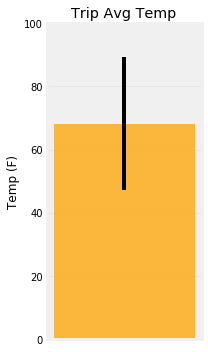

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize= (3,5))
plt.bar(days, TAVG, yerr=TMAX-TMIN, color = 'orange', alpha = .75)
plt.ylim(0, 100)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.grid(alpha=.25)
plt.tight_layout()
plt.savefig('Images\Trip_Avg_Temp.png')
plt.show()

### Daily Rainfall Average

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]

total_rainfall =(session.query(*sel)\
                       .filter(Station.station == Measurement.station)
                       .filter(func.strftime("%Y-%m-%d", Measurement.date) >= previous_year_start_date)\
                       .filter(func.strftime("%Y-%m-%d", Measurement.date) <= previous_year_end_date)\
                       .group_by(Station.station)\
                       .order_by(func.sum(Measurement.prcp).desc())\
                       .all())

#store query object data values in dictionary
total_rainfall_list = []                          
for station,name,total_rainfall,latitude,longitude,elevation  in total_rainfall:
    total_rainfall_dict = {}
    total_rainfall_dict["Station ID"] = station
    total_rainfall_dict["Station Name"] = name
    total_rainfall_dict["Total Rainfall"] = total_rainfall
    total_rainfall_dict["Latitude"] = latitude
    total_rainfall_dict["Longitude"] = longitude
    total_rainfall_dict["Elevation"] = elevation
    total_rainfall_list.append(total_rainfall_dict)


#convert list of dictionary to data frame
total_rainfall_df = pd.DataFrame(total_rainfall_list)
total_rainfall_df



,Station ID,Station Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.63,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.63,21.52130,-157.83740,7.0
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.61,21.33556,-157.71139,19.5
3,USC00513117,"KANEOHE 838.1, HI US",0.35,21.42340,-157.80150,14.6
4,USC00519281,"WAIHEE 837.5, HI US",0.20,21.45167,-157.84889,32.9
5,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
date_list = [(trip_Start_Date + dt.timedelta(days = i)) for i in range(0, days)]

# Stip off the year and save a list of %m-%d strings
date_list_m_d =[dt.datetime.strftime(date, '%m-%d') for date in date_list]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in date_list_m_d]
normals


[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_list = [np.ravel(normal[0]) for normal in normals]

#convert normals list into a data frame
normals_df = pd.DataFrame(normals_list)
# add date column
normals_df["Date"] = date_list
# set index and rename columns
normals_df.set_index("Date",inplace = True)
normals_df = normals_df.rename(columns={0: "TMIN", 1: "TAVG", 2: "TMAX"})

normals_df


,TMIN,TAVG,TMAX
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0
2018-01-08,57.0,67.160714,75.0
2018-01-09,58.0,67.929825,78.0


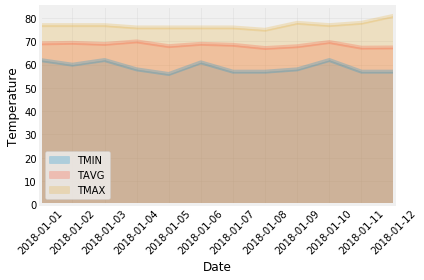

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=.25)
tick_locations = [dt.datetime.strftime(date, '%Y-%m-%d') for date in date_list]
plt.xticks(normals_df.index, tick_locations, rotation=45)
plt.ylabel("Temperature")
plt.grid(alpha = 0.25)
plt.tight_layout()
plt.savefig('Images\Daily_Normals.png')
plt.show()
